# Retinal Blood Vessels Segmentation
### `IABI Course, Dr. Rohban`
#### Homework 1
*`Full Name:`* Fatemeh Shahhosseini

*`SID:`* 403206519

## Proposed Method Description


In this notebook, we aim to extract suitable features using **image processing techniques**,
to obtain a **20-dimensional feature vector** for each pixel. Then, by using a **simple neural network**,
we train the model to learn these features. The goal is for the network to predict, for the **pixels in the test images**,
whether the pixels belong to **vessels** or the **background**.

<p align="left">
<img src="https://drive.usercontent.google.com/download?id=1wpOngGlh_wRui368o22RlfrzPOp7HZKq&export=download&authuser=0&confirm=t&uuid=ccc851a6-589d-47a1-94c5-75343b6e3427&at=AN_67v00Rdv1c_MovmsIyGdovxg6:1727563819162" alt="" width="500"/>
</p>

In [1]:
!pip install gdown

In [6]:
! gdown 1Z1vEpzO2W4TEQmQU-VhWKBg1-u40LUte

Error:

	HTTPSConnectionPool(host='drive.google.com', port=443): Max retries
	exceeded with url: /uc?id=1Z1vEpzO2W4TEQmQU-VhWKBg1-u40LUte (Caused by
	NewConnectionError('<urllib3.connection.HTTPSConnection object at
	0x0000021E560EFE50>: Failed to establish a new connection: [Errno
	11001] getaddrinfo failed'))

To report issues, please visit https://github.com/wkentaro/gdown/issues.


In [2]:
import cv2
import imageio
import numpy as np
import pandas as pd
from os import listdir
import scipy.ndimage as ndi
from typing import *
from scipy.stats import kurtosis, skew
import matplotlib.pyplot as plt
from os.path import isfile, join
import skimage.measure
from skimage.morphology import disk
#from google.colab.patches import cv2_imshow
from tqdm import tqdm

In [3]:
def plot_images(images: list[np.ndarray], titles=[]):
    plt.figure(figsize=(16, 3))
    for i in range(len(images)):
        plt.subplot(1, len(images), i+1)
        if len(titles) > i:
            plt.title(titles[i])
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')

    plt.show()

**DRIVE Dataset Overview:**

In this notebook, the DRIVE dataset has been used, which contains two sets of images: train and test. Each set includes 20 retinal images. For each image, there is a corresponding mask that defines the region of the retina within the image.

The label associated with each image is a binary image where the vessels are represented by the value 255 and the background by the value 0.

Important: Pathological features related to each image are not specified in the dataset.

Note: The labels for the test images are provided by two specialists.

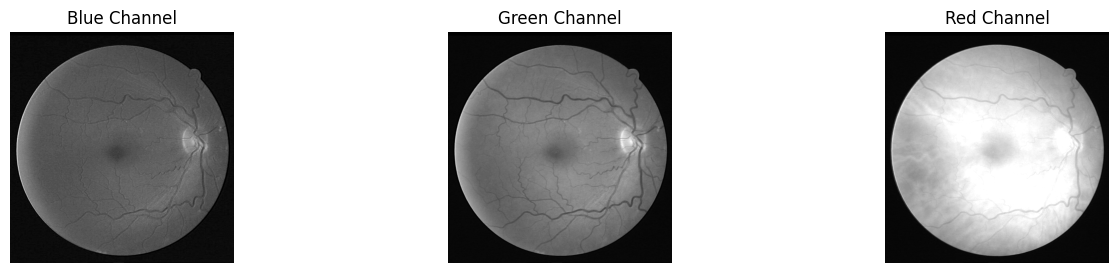

In [4]:
test_img = cv2.imread('DRIVE/Training/images/22_training.tif')
test_mask = np.array(imageio.mimread('DRIVE/Training/mask/22_training_mask.gif')).reshape(584, 565)

plot_images([test_img[:, :, 0], test_img[:, :, 1], test_img[:, :, 2]], ["Blue Channel", "Green Channel", "Red Channel"])

You must select one of the red, green, or blue channels from the color image `(Explain your reasoning for the selection)`.

`Your response (2 pts):`Green Channel is the best. The red channel tends to emphasize higher intensity areas and the blue channel often contains lower intensity information, which might result in a darker and potentially less detailed image. But the Green Channel (G) is typically the best for grayscale conversion because it often balances both detail and contrast well.

## Pre-Process (10 pts)

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def PreProcess(image: np.ndarray, mask: np.ndarray, plot_image: bool = False) -> np.ndarray:

    # Convert mask to a binary mask
    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    
    # Replace zero-mask pixels in the image with the mean of the masked image
    masked_image = cv2.bitwise_and(image, image, mask=binary_mask)
    mean_value = np.mean(masked_image[masked_image > 0])  # Only consider non-zero pixels in the masked image
    image[binary_mask == 0] = mean_value  # Replace zero-mask areas with the mean value
    
    # Perform morphological opening to remove small noise
    SE = disk(2)  # Structuring element for morphological operations
    opening = cv2.morphologyEx(image, cv2.MORPH_OPEN, SE)
    
    # Step 4: Apply CLAHE for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=7.0, tileGridSize=(8, 8))
    clh = clahe.apply(opening)
    
    # Step 5: Apply median filtering for noise smoothing
    median = cv2.medianBlur(clh, 5)
    
    # Plot the images at different steps if requested
    if plot_image:
        plot_images([image, masked_image, opening, clh, median], ["Original Image", "Masked Image", "Mrphological Opening", "Contrast Enhanced", "Smoothed Image"])
    
    # Return the final processed image, combining it with the mask
    return np.multiply(median, binary_mask//255)

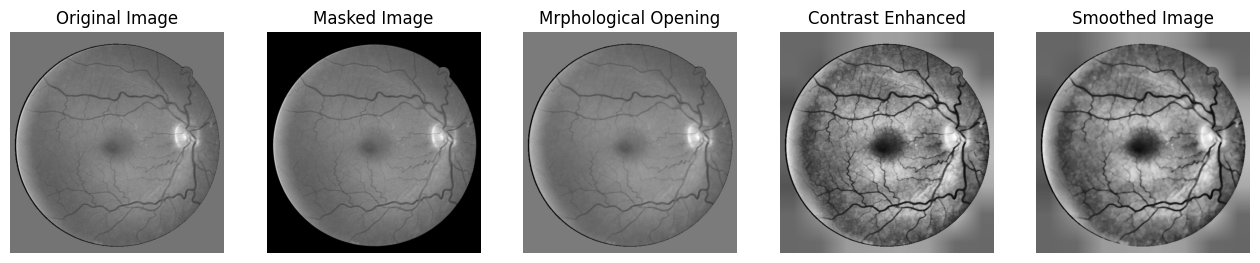

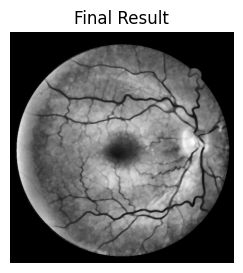

In [6]:
test_img_preprocessed = PreProcess(test_img[:, :, 1], test_mask, plot_image=True)
plot_images([test_img_preprocessed], ["Final Result"])

## Feature Extraction (70 pts)

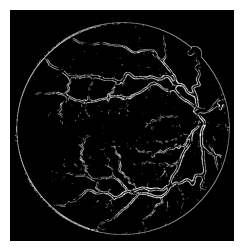

In [7]:
def Roberts_Edge_Detection(image):
  
    # Roberts Edge Detection: The Roberts operator measures a 2-D spatial gradient on an image in a straightforward, quick-to-compute manner.
    
    image = image.astype('float64')/255.0
    roberts_cross_v = np.array([[1,0],[0,-1]])
    roberts_cross_h = np.array([[0,1],[-1,0]])
    
    vertical = cv2.filter2D(image, -1, roberts_cross_v)
    horizontal = cv2.filter2D(image, -1, roberts_cross_h)
    edged_img_sqrt = np.sqrt(np.square(vertical) + np.square(horizontal))
    edged_img = np.clip(edged_img_sqrt * 255.0, 0, 255).astype(np.uint8)
    _, edged_img_thersh = cv2.threshold(edged_img, 30, 255, cv2.THRESH_BINARY)

    return edged_img_thersh
    
test_edged_img=Roberts_Edge_Detection(test_img_preprocessed)
plot_images([test_edged_img])

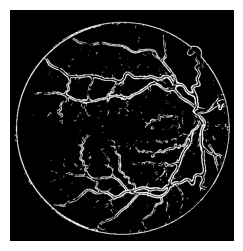

In [8]:
def Prewitt_Edge_Detection(image):
 
    #Prewitt mask is a first-order derivative mask. In the graph representation of Prewitt-mask’s result, the edge is represented by the local maxima or local minima.
    
    kernelx = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]]) 
    kernely = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
    
    image = image.astype('float64')/255.0
    
    img_prewittx = cv2.filter2D(image, -1, kernelx)
    img_prewitty = cv2.filter2D(image, -1, kernely)
    
    edged_img_sqrt = np.sqrt(np.square(img_prewittx) + np.square(img_prewitty))
    edged_img = np.uint8(255 * edged_img_sqrt / np.max(edged_img_sqrt))
    _, edged_img_thresh = cv2.threshold(edged_img, 30, 255, cv2.THRESH_BINARY)
    
    return edged_img_thresh
    
test_edged_img=Prewitt_Edge_Detection(test_img_preprocessed)
plot_images([test_edged_img])

In [9]:
def plot_histogram(image: np.ndarray):
    plt.figure(figsize=(8, 6))
    plt.hist(image.ravel(), bins=256, range=[np.min(image), np.max(image)], color='black')
    plt.title('Pixel Intensity Histogram')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

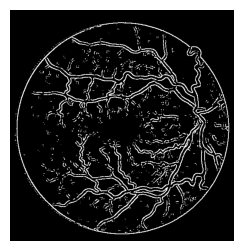

In [43]:

def LOG_Edge_Detection(image, morph_kernel_size=(5,5)):
  
    blur = cv2.GaussianBlur(image, (7, 7), 1)

    LoG = cv2.Laplacian(blur, cv2.CV_64F, ksize=3)

    # kernel = np.ones((3, 3), dtype=np.uint8)  
    # kernel = np.array([[1, 1, 1],
    #                    [1, 1, 1],
    #                    [1, 1, 1]], dtype=np.uint8) 
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, morph_kernel_size)
    minLoG = cv2.morphologyEx((LoG<-20).astype(np.uint8), cv2.MORPH_DILATE, kernel)
    maxLoG = cv2.morphologyEx((LoG>20).astype(np.uint8), cv2.MORPH_DILATE, kernel)
    
    zeroCross = np.logical_or(
        np.logical_and(minLoG < 0, LoG > 0),
        np.logical_and(maxLoG > 0, LoG < 0)
    ).astype(np.uint8) * 255

    return zeroCross


test_edged_img = LOG_Edge_Detection(test_img_preprocessed)
plot_images([test_edged_img])

In [44]:
def Sobel_Edge_Detection(image: np.ndarray, threshold=30) -> np.ndarray:

    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # Horizontal edges
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)  # Vertical edges
    
    sobel_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    
    # Step 3: Normalize the gradient magnitude to [0, 255] and threshold the result
    sobel_magnitude = np.uint8(np.clip(sobel_magnitude / np.max(sobel_magnitude) * 255, 0, 255))
    _, sobel_edges = cv2.threshold(sobel_magnitude, threshold, 255, cv2.THRESH_BINARY)
    
    return sobel_edges

In [45]:
def Canny_Edge_Detection(image: np.ndarray, low_threshold=50, high_threshold=150) -> np.ndarray:

    blur = cv2.GaussianBlur(image, (5, 5), 1.4)
    canny_edges = cv2.Canny(blur, low_threshold, high_threshold)
    
    return canny_edges

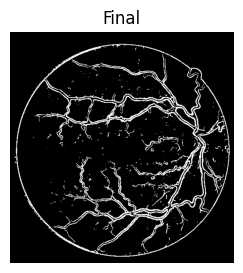

In [46]:
def Edge_Algorithm_features(image):
   
    #Roberts, Prewitt, Sobel, Canny, Log
    R = Roberts_Edge_Detection(test_img_preprocessed)
    P = Prewitt_Edge_Detection(test_img_preprocessed)
    S = Sobel_Edge_Detection(test_img_preprocessed)
    # _, S = None
    C = Canny_Edge_Detection(test_img_preprocessed)
    L = LOG_Edge_Detection(test_img_preprocessed)

    # plot_images([R, P, S, C, L], ["Roberts", "Prewitt", "Sobel", "Canny", "Log"])
    
    return R + P + S + C
    # return R , P ,  S , C, L
    
test_edged_img=Edge_Algorithm_features(test_img_preprocessed)
plot_images([test_edged_img], ["Final"])
# R , P ,  S , C, L =Edge_Algorithm_features(test_img_preprocessed)
# plot_images([R, P, S, C, L])
# plot_images([R+ P+ S+ C+ L, R+ P+ S+ C])

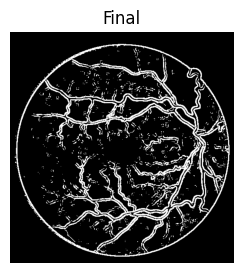

In [48]:
def Edge_Algorithm_features(image):
   
    #Roberts, Prewitt, Sobel, Canny, Log
    R = Roberts_Edge_Detection(test_img_preprocessed)
    P = Prewitt_Edge_Detection(test_img_preprocessed)
    S = Sobel_Edge_Detection(test_img_preprocessed)
    # _, S = None
    C = Canny_Edge_Detection(test_img_preprocessed)
    L = LOG_Edge_Detection(test_img_preprocessed)

    # plot_images([R, P, S, C, L], ["Roberts", "Prewitt", "Sobel", "Canny", "Log"])
    
    return R + P + S + C + L
    # return R , P ,  S , C, L
    
test_edged_img=Edge_Algorithm_features(test_img_preprocessed)
plot_images([test_edged_img], ["Final"])
# R , P ,  S , C, L =Edge_Algorithm_features(test_img_preprocessed)
# plot_images([R, P, S, C, L])
# plot_images([R+ P+ S+ C+ L, R+ P+ S+ C])

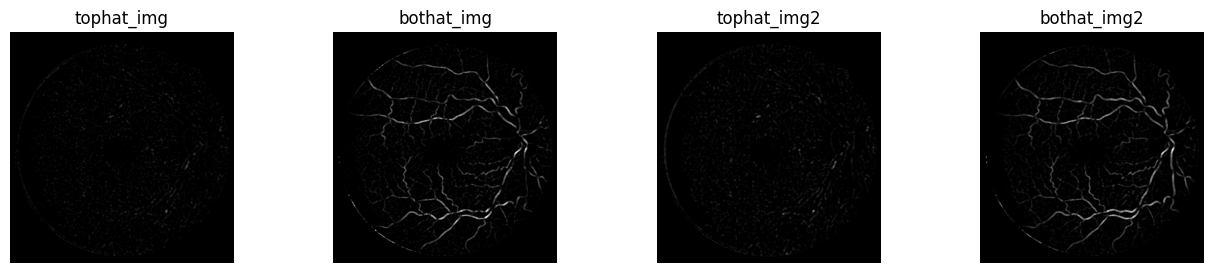

In [49]:
def Morphological_features(image):
  # Define the first structuring element (e.g., square kernel of size 5x5)
    kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

    # Apply top-hat and black-hat transformations with the first kernel
    tophat_img = cv2.morphologyEx(image, cv2.MORPH_TOPHAT, kernel1)
    bothat_img = cv2.morphologyEx(image, cv2.MORPH_BLACKHAT, kernel1)

    # Define a second structuring element (e.g., elliptical kernel of size 7x7)
    kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))

    # Apply top-hat and black-hat transformations with the second kernel
    tophat_img2 = cv2.morphologyEx(image, cv2.MORPH_TOPHAT, kernel2)
    bothat_img2 = cv2.morphologyEx(image, cv2.MORPH_BLACKHAT, kernel2)

    return tophat_img, bothat_img, tophat_img2, bothat_img2
    
test_morph_image=Morphological_features(test_img_preprocessed)
plot_images(test_morph_image, ['tophat_img', 'bothat_img', 'tophat_img2', 'bothat_img2'])


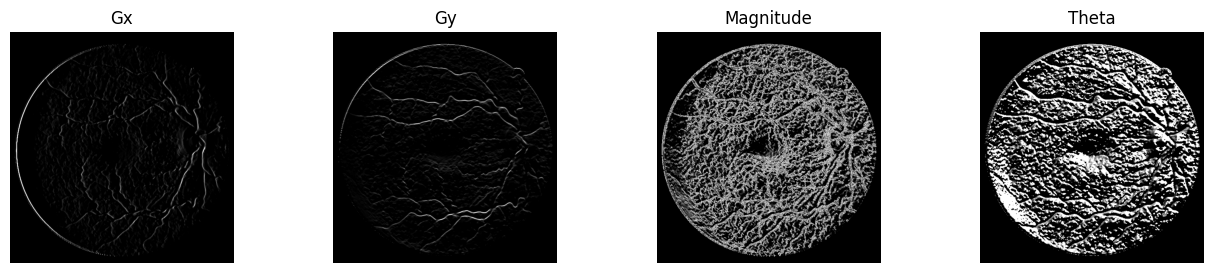

In [62]:
def Gradient_Based_features (image) :
    
    dx_kernel = np.array([[-0.5, 0, 0.5],
                          [-1, 0, 1],
                          [-0.5, 0, 0.5]], dtype=np.float32)

    dy_kernel = np.array([[-0.5, -1, -0.5],
                          [ 0,  0,  0],
                          [ 0.5,  1, 0.5]], dtype=np.float32)

   
    Gx = cv2.filter2D(image, -1, dx_kernel)
    Gy = cv2.filter2D(image, -1, dy_kernel)

   
    M = np.sqrt(Gx**2 + Gy**2)

   
    Theta = np.arctan2(Gy, Gx)

    return Gx, Gy, M, Theta
    
test_gradient_image=Gradient_Based_features(test_img_preprocessed)
plot_images(test_gradient_image, ['Gx', 'Gy', 'Magnitude', 'Theta'])

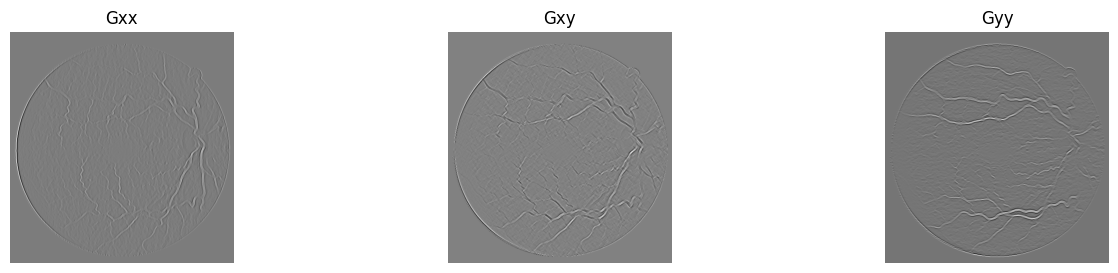

In [54]:
def Hessian_features(image) :
  # First, apply the Sobel operator to get first-order derivatives
    Ix = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # Derivative in x direction
    Iy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)  # Derivative in y direction

    # Now calculate second-order derivatives
    Gxx = cv2.Sobel(Ix, cv2.CV_64F, 1, 0, ksize=3)    # Second derivative in x (∂²I/∂x²)
    Gxy = cv2.Sobel(Ix, cv2.CV_64F, 0, 1, ksize=3)    # Mixed derivative (∂²I/∂x∂y)
    Gyy = cv2.Sobel(Iy, cv2.CV_64F, 0, 1, ksize=3)    # Second derivative in y (∂²I/∂y²)

    return Gxx, Gxy, Gyy

test_hessian_image=Hessian_features(test_img_preprocessed)
plot_images(test_hessian_image, ['Gxx', 'Gxy', 'Gyy'])

In [68]:
from scipy.stats import skew, kurtosis
import time

def Statistical_features(image, index):
    k = 10
    img = cv2.copyMakeBorder(image, k, k, k, k, cv2.BORDER_CONSTANT, None, image.mean())
    output = np.zeros((image.shape[0], image.shape[1], 8))
    X, Y = index

    for idx in (range(len(index[0]))):
    
            i = X[idx] + k
            j = Y[idx] + k

            patch = img[i-k:i+k+1, j-k:j+k+1].flatten()

            mean = np.mean(patch)
            output[i-2*k, j-2*k, 0] = mean #mean
            output[i-2*k, j-2*k, 1] = np.min(patch) #min
            output[i-2*k, j-2*k, 2] = np.max(patch) #max
            output[i-2*k, j-2*k, 3] = skew(patch) #skew
            output[i-2*k, j-2*k, 4] = kurtosis(patch) #kurtosis
            output[i-2*k, j-2*k, 5] = np.std(patch) #std
            output[i-2*k, j-2*k, 6] = np.mean(np.abs(patch - mean)) #mean absolute deviation
            output[i-2*k, j-2*k, 7] = np.sqrt(np.sum(patch ** 2)) #root sum of squared level

    return [stat for stat in output[:, :]]


print(time.strftime("%H:%M:%S"))
index = np.where(test_mask != 0)
test_statistic_features=Statistical_features(test_img_preprocessed,index)
mean, min, max, Skewness, Kurtosis, std, mad, sqrt = np.transpose(test_statistic_features, (2, 0, 1))[:]
test_statistic_features=np.stack((mean[index],  min[index],  max[index],  Skewness[index],  Kurtosis[index],  std[index],  mad[index],  sqrt[index]), axis=1)
data = pd.DataFrame()
df = pd.DataFrame(test_statistic_features)
print(time.strftime("%H:%M:%S"))

23:53:19
23:57:00




1. **Setup Paths**: Defines paths for images, masks, and labels from the DRIVE dataset.
   
2. **Load File Lists**: Retrieves and sorts the filenames for images, masks, and labels from the specified directories.

3. **Initialize DataFrame**: Creates an empty DataFrame to store the extracted features from each processed image.

4. **Image Processing Loop**: Iterates over the first 20 images:
   - Reads each image and its corresponding mask and label.
   - Reshapes the mask and label arrays to standard dimensions.
   - Converts label values from 255 to 1 for binary representation.
   - Applies preprocessing to the image using the `PreProcess` function.

5. **Feature Extraction**: Extracts various features from the preprocessed image:
   - Edge features using the `Edge_Algorithm_features` function.
   - Morphological features using the `Morphological_features` function.
   - Statistical features (mean, min, max, skewness, kurtosis, standard deviation, mean absolute deviation, and root sum of squares) using the `Statistical_features` function.
   - Gradient-based features (Gx, Gy, magnitude, and angle) using the `Gradient_Based_features` function.
   - Hessian features using the `Hessian_features` function.

6. **Feature Compilation**: Stacks the extracted features along with the corresponding label and creates a DataFrame from the features.

7. **Data Storage**: Concatenates the newly created DataFrame with the main DataFrame to accumulate all extracted features.

This step prepares the data for  model training.



In [69]:
train_image_path = 'DRIVE/Training/images/'
train_mask_path = 'DRIVE/Training/mask/'
train_label_path = 'DRIVE/Training/1st_manual/'

test_image_path = 'DRIVE/Test/images/'
test_mask_path = 'DRIVE/Test/mask/'
test_label_path = 'DRIVE/Test/1st_manual/'

data = pd.DataFrame()

import time 
import gc

def extract_features(image_path, mask_path, label_path, i, j):
        global data
        images = [f for f in listdir(image_path) if isfile(join(image_path, f))][i:j]
        images.sort()
        masks = [f for f in listdir(mask_path) if isfile(join(mask_path, f))][i:j]
        masks.sort()
        labels = [f for f in listdir(label_path) if isfile(join(label_path, f))][i:j]
        labels.sort()
        
        
        for i in tqdm(range(len(images))) :
            image = cv2.imread(join(image_path, images[i]))
            mask = np.array(imageio.mimread(join(mask_path, masks[i]))).reshape(584, 565)
            label = np.array(imageio.mimread(join(label_path, labels[i]))).reshape(584, 565)
            label[np.where(label == 255)] = 1
            index = np.where(mask != 0)
            image = PreProcess(image[:, :, 1], mask,False)

            ################# feature extraction######################################
            print("feature exctraction begin", time.strftime("%H:%M:%S"))
            edges = Edge_Algorithm_features(image)
            print("Edge_Algorithm_features ended", time.strftime("%H:%M:%S"))
            
            (tophat, bothat, tophat2, bothat2) = Morphological_features(image)
            print("Morphological_features ended", time.strftime("%H:%M:%S"))
            
            (Gx, Gy, M, Theta) = Gradient_Based_features(image)
            print("Gradient_Based_features ended", time.strftime("%H:%M:%S"))
            
            (Gxx, Gxy, Gyy) = Hessian_features(image)
            print("Hessian_features ended", time.strftime("%H:%M:%S"))
            
            mean, min, max, Skewness, Kurtosis, std, mad, sqrt = np.transpose(Statistical_features(image, index), (2, 0, 1))[:]
            print("Statistical_features ended", time.strftime("%H:%M:%S"))
            
            features = np.stack((edges[index], tophat[index], bothat[index], Gx[index], Gy[index], tophat2[index], bothat2[index],
                                mean[index],  min[index],  max[index],  Skewness[index],  Kurtosis[index],  std[index],  mad[index],  sqrt[index],
                                M[index], Theta[index], Gxx[index], Gxy[index], Gyy[index], label[index]), axis=1)
            print("stack ended", time.strftime("%H:%M:%S"))
            
            df = pd.DataFrame(features)
            data = pd.concat([data, df])
            data.to_csv("test_data.csv", index=False)
            print("Data part" + str(i) +" stored successfully!")
            
            del image, features, df
            gc.collect()
            
        return data

# train data

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

feature exctraction begin 19:11:57


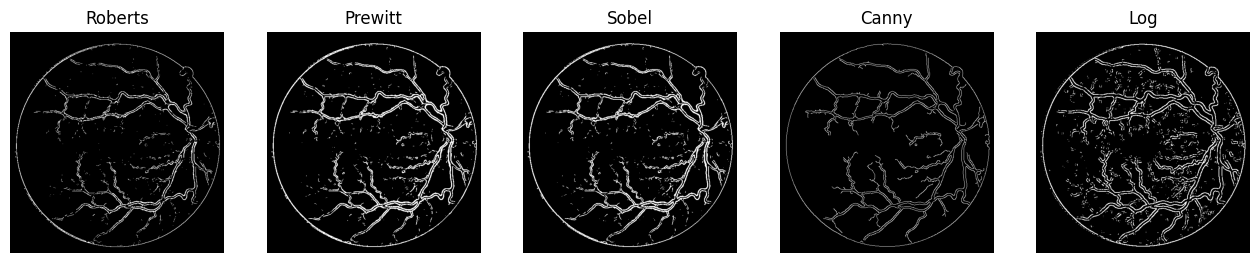

Edge_Algorithm_features ended 19:11:57
Morphological_features ended 19:11:57
Gradient_Based_features ended 19:11:58
Hessian_features ended 19:11:58



  0%|                                                                                           | 0/20 [02:08<?, ?it/s]


KeyboardInterrupt: 

In [36]:
df_train = extract_features(train_image_path, train_mask_path, train_label_path)
df_train.to_csv("train.csv")

In [ ]:
df_train = extract_features(train_image_path, train_mask_path, train_label_path)
df_train.to_csv("train2.csv")

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

feature exctraction begin 22:26:09
Edge_Algorithm_features ended 22:26:09
Morphological_features ended 22:26:09
Gradient_Based_features ended 22:26:09
Hessian_features ended 22:26:09



 55%|████████████████████████████████████████▎                                | 124603/225600 [02:47<02:21, 715.32it/s]

In [108]:
df_train = extract_features(train_image_path, train_mask_path, train_label_path, 0, 21)
df_train.to_csv("trainTotal.csv")

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

feature exctraction begin 19:46:24
Edge_Algorithm_features ended 19:46:24
Morphological_features ended 19:46:24
Gradient_Based_features ended 19:46:24
Hessian_features ended 19:46:24
Statistical_features ended 19:50:28
stack ended 19:50:29


  5%|████                                                                            | 1/20 [07:40<2:25:44, 460.23s/it]

Data part0 stored successfully!
feature exctraction begin 19:54:04
Edge_Algorithm_features ended 19:54:04
Morphological_features ended 19:54:04
Gradient_Based_features ended 19:54:04
Hessian_features ended 19:54:04
Statistical_features ended 19:57:44
stack ended 19:57:44


 10%|████████                                                                        | 2/20 [14:50<2:12:44, 442.49s/it]

Data part1 stored successfully!
feature exctraction begin 20:01:14
Edge_Algorithm_features ended 20:01:14
Morphological_features ended 20:01:14
Gradient_Based_features ended 20:01:14
Hessian_features ended 20:01:14
Statistical_features ended 20:04:44
stack ended 20:04:44
Data part2 stored successfully!


 15%|████████████                                                                    | 3/20 [21:51<2:02:38, 432.87s/it]

feature exctraction begin 20:08:15
Edge_Algorithm_features ended 20:08:16
Morphological_features ended 20:08:16
Gradient_Based_features ended 20:08:16
Hessian_features ended 20:08:16
Statistical_features ended 20:11:43
stack ended 20:11:43


 20%|████████████████                                                                | 4/20 [28:58<1:54:49, 430.59s/it]

Data part3 stored successfully!
feature exctraction begin 20:15:22
Edge_Algorithm_features ended 20:15:23
Morphological_features ended 20:15:23
Gradient_Based_features ended 20:15:23
Hessian_features ended 20:15:23
Statistical_features ended 20:18:57
stack ended 20:18:57


 25%|████████████████████                                                            | 5/20 [36:26<1:49:10, 436.71s/it]

Data part4 stored successfully!
feature exctraction begin 20:22:50
Edge_Algorithm_features ended 20:22:50
Morphological_features ended 20:22:50
Gradient_Based_features ended 20:22:50
Hessian_features ended 20:22:50
Statistical_features ended 20:26:25
stack ended 20:26:25


 30%|████████████████████████                                                        | 6/20 [43:49<1:42:25, 438.97s/it]

Data part5 stored successfully!
feature exctraction begin 20:30:13
Edge_Algorithm_features ended 20:30:14
Morphological_features ended 20:30:14
Gradient_Based_features ended 20:30:14
Hessian_features ended 20:30:14
Statistical_features ended 20:33:44
stack ended 20:33:44


 35%|████████████████████████████                                                    | 7/20 [51:12<1:35:20, 440.05s/it]

Data part6 stored successfully!
feature exctraction begin 20:37:36
Edge_Algorithm_features ended 20:37:36
Morphological_features ended 20:37:36
Gradient_Based_features ended 20:37:36
Hessian_features ended 20:37:36
Statistical_features ended 20:41:06
stack ended 20:41:06


 40%|████████████████████████████████                                                | 8/20 [58:42<1:28:39, 443.30s/it]

Data part7 stored successfully!
feature exctraction begin 20:45:06
Edge_Algorithm_features ended 20:45:06
Morphological_features ended 20:45:06
Gradient_Based_features ended 20:45:06
Hessian_features ended 20:45:06
Statistical_features ended 20:48:43
stack ended 20:48:43


 45%|███████████████████████████████████                                           | 9/20 [1:06:20<1:22:05, 447.82s/it]

Data part8 stored successfully!
feature exctraction begin 20:52:44
Edge_Algorithm_features ended 20:52:44
Morphological_features ended 20:52:44
Gradient_Based_features ended 20:52:44
Hessian_features ended 20:52:44
Statistical_features ended 20:56:11
stack ended 20:56:11


 50%|██████████████████████████████████████▌                                      | 10/20 [1:13:56<1:15:03, 450.38s/it]

Data part9 stored successfully!
feature exctraction begin 21:00:20
Edge_Algorithm_features ended 21:00:20
Morphological_features ended 21:00:20
Gradient_Based_features ended 21:00:20
Hessian_features ended 21:00:20
Statistical_features ended 21:03:48
stack ended 21:03:48


 55%|██████████████████████████████████████████▎                                  | 11/20 [1:21:34<1:07:54, 452.69s/it]

Data part10 stored successfully!
feature exctraction begin 21:07:58
Edge_Algorithm_features ended 21:07:58
Morphological_features ended 21:07:58
Gradient_Based_features ended 21:07:58
Hessian_features ended 21:07:58
Statistical_features ended 21:11:25
stack ended 21:11:25


 60%|██████████████████████████████████████████████▏                              | 12/20 [1:29:19<1:00:52, 456.51s/it]

Data part11 stored successfully!
feature exctraction begin 21:15:43
Edge_Algorithm_features ended 21:15:43
Morphological_features ended 21:15:43
Gradient_Based_features ended 21:15:43
Hessian_features ended 21:15:43
Statistical_features ended 21:19:10
stack ended 21:19:10


 65%|███████████████████████████████████████████████████▎                           | 13/20 [1:37:05<53:35, 459.32s/it]

Data part12 stored successfully!
feature exctraction begin 21:23:29
Edge_Algorithm_features ended 21:23:29
Morphological_features ended 21:23:29
Gradient_Based_features ended 21:23:29
Hessian_features ended 21:23:29
Statistical_features ended 21:27:01
stack ended 21:27:01


 70%|███████████████████████████████████████████████████████▎                       | 14/20 [1:44:59<46:24, 464.01s/it]

Data part13 stored successfully!
feature exctraction begin 21:31:24
Edge_Algorithm_features ended 21:31:24
Morphological_features ended 21:31:24
Gradient_Based_features ended 21:31:24
Hessian_features ended 21:31:24
Statistical_features ended 21:34:50
stack ended 21:34:50


 75%|███████████████████████████████████████████████████████████▎                   | 15/20 [1:52:57<39:00, 468.05s/it]

Data part14 stored successfully!
feature exctraction begin 21:39:21
Edge_Algorithm_features ended 21:39:22
Morphological_features ended 21:39:22
Gradient_Based_features ended 21:39:22
Hessian_features ended 21:39:22
Statistical_features ended 21:42:52
stack ended 21:42:52


 80%|███████████████████████████████████████████████████████████████▏               | 16/20 [2:01:10<31:42, 475.56s/it]

Data part15 stored successfully!
feature exctraction begin 21:47:34
Edge_Algorithm_features ended 21:47:34
Morphological_features ended 21:47:34
Gradient_Based_features ended 21:47:34
Hessian_features ended 21:47:34
Statistical_features ended 21:51:07
stack ended 21:51:07


 85%|███████████████████████████████████████████████████████████████████▏           | 17/20 [2:09:36<24:14, 484.68s/it]

Data part16 stored successfully!
feature exctraction begin 21:56:00
Edge_Algorithm_features ended 21:56:00
Morphological_features ended 21:56:00
Gradient_Based_features ended 21:56:00
Hessian_features ended 21:56:00
Statistical_features ended 21:59:29
stack ended 21:59:29


 90%|███████████████████████████████████████████████████████████████████████        | 18/20 [2:18:04<16:23, 491.64s/it]

Data part17 stored successfully!
feature exctraction begin 22:04:28
Edge_Algorithm_features ended 22:04:28
Morphological_features ended 22:04:28
Gradient_Based_features ended 22:04:28
Hessian_features ended 22:04:28
Statistical_features ended 22:08:04
stack ended 22:08:04


 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [2:26:35<08:17, 497.45s/it]

Data part18 stored successfully!
feature exctraction begin 22:12:59
Edge_Algorithm_features ended 22:12:59
Morphological_features ended 22:12:59
Gradient_Based_features ended 22:12:59
Hessian_features ended 22:12:59
Statistical_features ended 22:16:26
stack ended 22:16:26


100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [2:35:04<00:00, 465.21s/it]

Data part19 stored successfully!


In [110]:
df_train

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,16,17,18,19,20
0,0.0,254.0,33.0,0.0,118.0,248.0,34.0,0.0,104.147392,77.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,254.0,32.0,0.0,0.0,222.0,33.0,0.0,103.684807,77.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,251.0,6.0,1.0,0.0,208.0,7.0,0.0,103.498866,77.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,251.0,6.0,1.0,0.0,208.0,7.0,0.0,103.646259,77.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,251.0,4.0,1.0,2.0,210.0,7.0,0.0,104.020408,77.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,-10.0,-6.0,-530.0,0.0
226970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,-532.0,0.0
226971,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,2.0,0.0,-188.0,-6.0,-476.0,0.0
226972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,-212.0,-18.0,-212.0,0.0


# test data

In [111]:
df_test = extract_features(test_image_path, test_mask_path, test_label_path,0, 21)
df_test.to_csv("test.csv")

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

feature exctraction begin 22:54:34
Edge_Algorithm_features ended 22:54:34
Morphological_features ended 22:54:34
Gradient_Based_features ended 22:54:34
Hessian_features ended 22:54:34
Statistical_features ended 22:58:15
stack ended 22:58:15


  5%|████                                                                            | 1/20 [09:05<2:52:53, 545.99s/it]

Data part0 stored successfully!
feature exctraction begin 23:03:40
Edge_Algorithm_features ended 23:03:40
Morphological_features ended 23:03:40
Gradient_Based_features ended 23:03:40
Hessian_features ended 23:03:40
Statistical_features ended 23:07:09
stack ended 23:07:09


  5%|████                                                                            | 1/20 [12:35<3:59:09, 755.22s/it]


MemoryError: Unable to allocate 2.56 GiB for an array with shape (21, 16338130) and data type float64

## Training Phase (18 pts)

In [93]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

- **Note**: Due to the significant differences in the scale of the extracted features, the values should normalize before training the neural network.


In [106]:
sc = StandardScaler()

shuffled = df_train.sample(frac=1)
X_train = sc.fit_transform(shuffled.iloc[:, 1:21])
Y_train = shuffled.iloc[:, -1].astype(int).to_numpy()


X_test = sc.fit_transform(df_test.iloc[:, 1:21])
Y_test = df_test.iloc[:, -1].astype(int).to_numpy()

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

- **Note**: Since the number of foreground pixels is much smaller than the background pixels, a weighted binary cross-entropy loss is used, with a higher weight assigned to errors in detecting blood vessels.(9pt)

In [ ]:

class MyDataset(Dataset):

  def __init__(self,X, Y):

    self.x_train=torch.tensor(X,dtype=torch.float32)
    self.y_train=torch.tensor(Y,dtype=torch.float32)

  def __len__(self):
    return len(self.y_train)

  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]


class Classifier(nn.Module):
   def __init__(self):
      super(Classifier, self).__init__()
      self.fc1 = nn.Linear(20, 32)
      self.fc2 = nn.Linear(32, 32)
      self.fc4 = nn.Linear(32,16)
      self.fc3 = nn.Linear(16,1)
   def forward(self, x):
      x = torch.tanh(self.fc1(x))
      x = torch.tanh(self.fc2(x))
      x = torch.tanh(self.fc4(x))
      return torch.sigmoid(self.fc3(x))

class weighted_binary_cross_entropy(nn.Module):
    def __init__(self):
      super(weighted_binary_cross_entropy, self).__init__()

    def forward(self, output, target, weights=None):
        output = torch.clamp(output,min=1e-8,max=1-1e-8)

        if weights is not None:
            assert len(weights) == 2
            #
            loss = weights[1] * target * torch.log(output) + weights[0] * (1 - target) * torch.log(1 - output)
        else:
            loss = target * torch.log(output) + (1 - target) * torch.log(1 - output)

        return torch.neg(torch.mean(loss))

In [ ]:
#####################################
###### DO NOT CHANGE THIS CELL ######
#####################################

N_EPOCHS = 20
BATCH_SIZE = 128
LR = 1e-2
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader = DataLoader(MyDataset(X_train, Y_train), batch_size=BATCH_SIZE, shuffle=False)
model = Classifier().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
criterion = weighted_binary_cross_entropy()

- After generating the probability of each pixel being part of a blood vessel. A fixed threshold of `0.4` should choose to binarize these values.

In [ ]:
# training loop
def train_model(model, train_dataloader, n_epochs, optimizer, criterion, device):
    model.train()
    train_losses = []
    train_accuracies = []
    for epoch in tqdm(range(n_epochs)):
    #################################################################################
    #                         YOUR CODE GOES HERE                                   #

        epoch_loss = 0
        correct=0
        total=0
        for data, target in train_dataloader:

            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            output = output.reshape(target.shape)
            loss = criterion(output, target, [1, 1.2])
            loss.backward()
            optimizer.step()

            predicted = output >= 0.4
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            epoch_loss += loss.item()

        accu=100.0*correct/total
        train_loss = epoch_loss / len(train_loader)
        train_accuracies.append(accu)
        train_losses.append(train_loss)

    #################################################################################
        print('Epoch: {}  Train Loss: {:.4f}  Accuracy: {:.3f}'.format(epoch+1, train_loss, accu))

    return model, train_losses, train_accuracies


In [ ]:
trained_model, train_losses, train_accuracies = train_model(model, train_loader, N_EPOCHS, optimizer, criterion, DEVICE)

--------------
In order to `evaluate` the method, three metrics will be used: accuracy, specificity, and sensitivity, each of which is defined as follows:

First, we define the parameters TP, TN, FP, and FN, which will be used to calculate the mentioned metrics.

`TP`: The number of pixels that are part of the vessel, and the method also correctly identifies them as vessels.

`TN`: The number of pixels that belong to the background, and the method also correctly identifies them as background.

`FP`: The number of pixels that belong to the background, but the method incorrectly identifies them as vessels.

`FN`: The number of pixels that are part of the vessel, but the method incorrectly identifies them as background.

With these definitions in place, the three metrics are defined as follows:


$
\text{Sensitivity} = \frac{TP}{TP + FN}
$


$
\text{Specificity} = \frac{TN}{TN + FP}
$


$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$


In [32]:
def evaluation(image, label, mask) :

  TP = TN =  FP = FN = 0
  row, col = image.shape
  for i in range(row):
    for j in range(col):

     # if mask[i, j] != 0:
        p = image[i, j]
        l = label[i, j]
        if p != 0 and l != 0:
          TP +=1
        elif p != 0 and l == 0 :
          FP +=1
        elif p == 0 and l == 0 :
          TN +=1
        elif p == 0 and l != 0 :
          FN +=1

  Sn = TP/(TP + FN)
  Sp = TN/(TN + FP)
  Acc = (TP + TN)/(TP + TN + FP + FN)

  return Sn, Sp, Acc

-----
- `Note`: you must reach at least `70%` sensitivity, `90%` specificity, and `90%` accuracy. (3 pts)


In [83]:
test_image_path = 'DRIVE/Test/images/'
test_mask_path = 'DRIVE/Test/mask/'
test_label_path = 'DRIVE/Test/1st_manual/'

images = [f for f in listdir(test_image_path) if isfile(join(test_image_path, f))]
images.sort()

masks = [f for f in listdir(test_mask_path) if isfile(join(test_mask_path, f))]
masks.sort()

labels = [f for f in listdir(test_label_path) if isfile(join(test_label_path, f))]
labels.sort()



sample_images = []
sum = 0
cnt = 0
sn = sp = acc = 0

for i in tqdm(range(len(images))) :
  image = cv2.imread(join(test_image_path, images[i]))
  mask = np.array(imageio.mimread(join(test_mask_path, masks[i]))).reshape(584, 565)
  label = np.array(imageio.mimread(join(test_label_path, labels[i]))).reshape(584, 565)
  label[np.where(label == 255)] = 1
  index = np.where(mask != 0)
  cnt = index[0].shape[0]

  temp = np.zeros((584, 565))
  X = torch.from_numpy(X_test[sum:sum+cnt, :]).to(DEVICE)
  Y = Y_test[sum:sum+cnt]

  out = model(X.float()).reshape(Y.shape) >= 0.4

  x, y = index
  for idx in range(cnt,) :
    m = x[idx]
    n = y[idx]

    if out[idx] == 1:
      temp[m, n] = 255

  sum += cnt

  ########## for removing borders of mask ##############
  border = LOG_Edge_Detection(mask)
  kernel = np.ones((4, 4), np.uint8)
  border = cv2.dilate(border.astype('uint8'), kernel, iterations=1)
  idx = np.where(border != 0)
  temp[idx] = 0

  SN, SP, ACC = evaluation(temp, label, mask)

  sn += SN
  sp += SP
  acc += ACC

  if len(sample_images) < 10:
    sample_images.append((image, label, temp))


print(sn/len(images))
print(sp/len(images))
print(acc/len(images))

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:39<00:00,  4.96s/it]

0.6670343318954377
0.9808480451036482
0.9532223602860952


- Show two sample images along with their ground truth and the model output at the end. (6 pts)

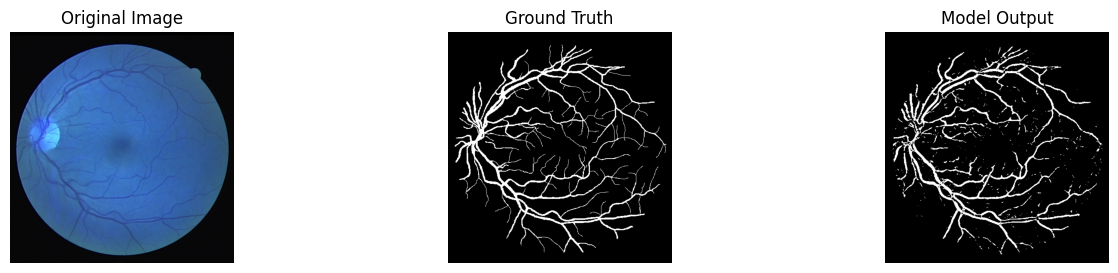

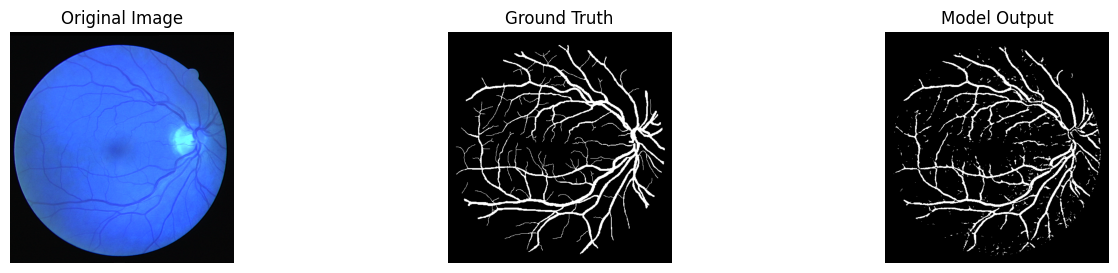

In [40]:
#################################################################################
#                         YOUR CODE GOES HERE                                   #
for (image, label, prediction) in sample_images[:2]:
    plot_images([image, label, prediction], ["Original Image", "Ground Truth", "Model Output"])